In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io
from astropy.stats.circstats import circcorrcoef
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from modelUtils import wrap_180, wrap_360, rot, scale_180_from_360, calc_sweep_times
from hdf_utils import unpack_hdf, Workspace
from scalebars import *
import deconv
from deconv import poisson_of_release, sum_quanta

from SacNetwork import SacNetwork
# import balance_configs as configs
import sac_mode_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
# %matplotlib notebook
%matplotlib widget
# %matplotlib qt
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams['svg.fonttype'] = 'none'  # don't save font as paths (assumes font present on machine)

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"

# TODO:
**timing offsets between EI for each direction:**
- collect input locations for EI synapses at each rho level
- calculate the time delta between E and I
- how does this change over direction?

In [4]:
model_path = os.path.join(base_path, "sanity")
fig_path = os.path.join(model_path, "figs") 
os.makedirs(fig_path, exist_ok=True)

dir_labels = np.array([225, 270, 315, 0, 45, 90, 135, 180])
circle = np.radians([0, 45, 90, 135, 180, 225, 270, 315, 0])
dir_rads = np.radians(dir_labels)
wrap_circ = lambda ds: np.concatenate((ds, [ds[0]]))
dirs_180 = np.array([ana.scale_180_from_360(d) for d in dir_labels])
dir_sort = np.argsort(dir_labels)
dir_180_sort = np.argsort(dirs_180)
dirs_sorted = dir_labels[dir_sort]
dirs_180_sorted = dirs_180[dir_sort]
circ_180 = np.concatenate((dirs_180_sorted, [-dirs_180_sorted[0]]))

# conf = configs.sac_mode_config()
conf = configs.decr_weight()
probs = {
    t: {
        "null": conf["synprops"][t]["null_prob"],
        "pref": conf["synprops"][t]["pref_prob"],
    }
    for t in ["E", "I"]
}
conf["sac_uniform_dist"] = {0: False, 1: False}  # unused dummy value
conf["sac_shared_var"] = 30  # unused dummy value
conf["sac_theta_vars"] = {"E": 60, "I": 60}  # unused dummy value
conf["sac_theta_mode"] = "experimental"  # used (supercedes above settings)

rng = np.random.default_rng()

In [5]:
quanta_h5 = "/mnt/Data/prerna_velocity/static_roi_waveforms/quantum_pack.h5"
with h5.File(quanta_h5, "r") as f:
    quantum_pack = unpack_hdf(f)
    
release_rates = quantum_pack["clipped_rates"]
rec_dt = quantum_pack["rec_dt"]
target_rate_dt = 0.001  # 0.0001
bp_inputs = {("sust" if k == "PD" else "trans"): r for k, r in quantum_pack["aligned_recs"].items()}
bp_inputs["sust"] = bp_inputs["sust"] * np.max(bp_inputs["trans"]) / np.max(bp_inputs["sust"])

vrate = deconv.velocity_rate(
    bp_inputs["trans"],
    rec_dt,
    quantum_pack["quantum"],
    1,
    rf=0.06,
    spot=0.2,
    bsln_start=100,
    bsln_end=150,
    step=1,
    offset=0.,
    model_dt=target_rate_dt,
)
vrate = np.clip(vrate, 0.0, np.inf)
vrate_xaxis = np.arange(len(vrate))

Text(0.5, 0, 'Time (ms)')

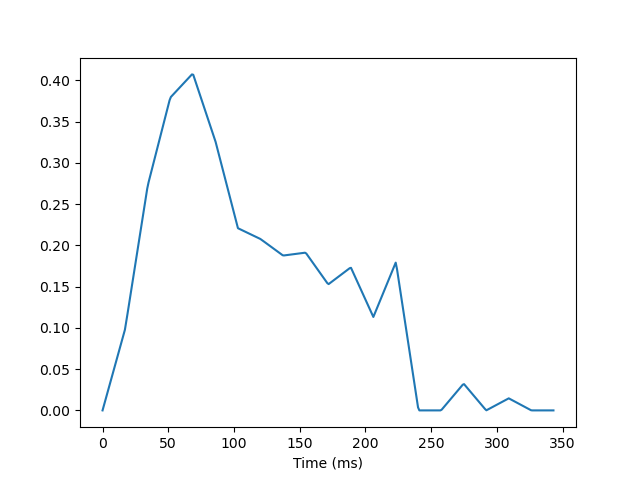

In [6]:
vrate_fig, vrate_ax = plt.subplots(1)
vrate_ax.plot(vrate_xaxis, vrate)
vrate_ax.set_xlabel("Time (ms)")

### Correlated Poisson train generation using a shared base

In [7]:
def poisson_shared_base(rng, rate, rho=0.8, i_scale=1, e_scale=0.8):
    inv_rho = 1 - rho
    # inv_rho = 1 - rho**2
    # inv_rho = np.sqrt(1 - rho**2)
    base_psn = poisson_of_release(rng, rate * rho)
    e_psn = np.round(
        e_scale * (base_psn + poisson_of_release(rng, rate * inv_rho))
    ).astype(int)
    i_psn = np.round(
        i_scale * (base_psn + poisson_of_release(rng, rate * inv_rho))
    ).astype(int)
    return base_psn, e_psn, i_psn
    
def poisson_correlation_shared_base(rate, i_scale=1, e_scale=0.8):
    rng = np.random.default_rng()
    base_total, e_total, i_total, corr = [], [], [], []
    for _ in range(10000):
        base_psn, e_psn, i_psn = poisson_shared_base(rng, rate, rho=0.8, i_scale=i_scale, e_scale=e_scale)
        base_total.append(np.sum(base_psn))
        i_total.append(np.sum(i_psn))
        e_total.append(np.sum(e_psn))
        corr.append(np.corrcoef(i_psn - rate * i_scale, e_psn - rate * e_scale)[0][1])

    print(
        "base total = %f\ni total = %f\ne total = %f\n corr = %f\n"
        % (np.mean(base_total), np.mean(i_total), np.mean(e_total), np.mean(corr))
    )
poisson_correlation_shared_base(vrate)

base total = 40.600600
i total = 50.758900
e total = 50.271500
 corr = 0.793272



### Correlated Poisson train generation using one train as the base of the other

In [8]:
def poisson_correlation_inhib_base(rate):
    rng = np.random.default_rng()
    rho = 0.6
    inv_rho = 1 - rho
    # inv_rho = 1 - rho**2
    # inv_rho = np.sqrt(1 - rho**2)
    # scale = 0.6
    scale = 1
    e_total, i_total, corr = [], [], []
    for _ in range(10000):
        i_psn = poisson_of_release(rng, rate)
        e_psn = np.round(
            scale * (i_psn * rho + poisson_of_release(rng, rate * inv_rho))
        ).astype(int)
        i_psn = np.round(scale * i_psn).astype(int)

        i_total.append(np.sum(i_psn))
        e_total.append(np.sum(e_psn))
        # corr.append(np.corrcoef(i_psn, e_psn)[0][1])
        corr.append(np.corrcoef(i_psn - np.mean(i_psn), e_psn - np.mean(e_psn))[0][1])

    print(
        "i total = %f\ne total = %f\n corr = %f\n"
        % (np.mean(i_total), np.mean(e_total), np.mean(corr))
    )
    
poisson_correlation_inhib_base(vrate)

i total = 50.745300
e total = 65.722000
 corr = 0.791204



### Generating correlated normal distributions

mvar corr: [[1.         0.79311181]
 [0.79311181 1.        ]]


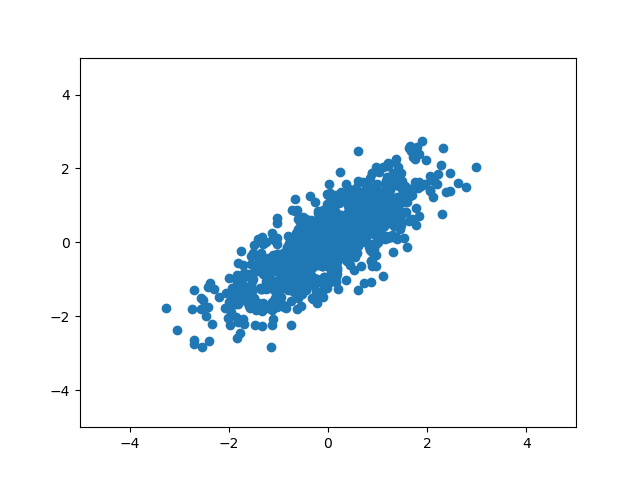

In [9]:
mvar_rho = 0.8
cov = np.array([[1, mvar_rho], [mvar_rho, 1]])
mvar = rng.multivariate_normal(np.zeros(2), cov, size=1000)
def mvar_fun(size):
    """Multivariate normal distribution with covariance matrix baked in."""
    return rng.multivariate_normal(np.zeros(2), cov, size=size)

def mvar_dumb(size):
    """Stationary pre-generated correlated values for sanity checking."""
    return mvar

def mvar_dumb_half(size):
    """Stationary pre-generated correlated values for sanity checking."""
    return mvar * 0.5

mvar_fig, mvar_ax = plt.subplots(1)
mvar_ax.scatter(mvar[:, 0], mvar[:, 1])
mvar_ax.set_xlim(-5, 5)
mvar_ax.set_ylim(-5, 5)
print("mvar corr:", np.corrcoef(mvar[:, 0], mvar[:, 1]))

### Generating 3 or more correlated normal distributions
Basic demonstration of constructing a covariance matrix for more than 2 distributions and using `multivariate_normal` to sample
This is used to correlate the noise of plexus dendrites as well.
Falloff of correlation should follow the same angular delta rule as EI correlations have been.

ab corr: 0.9026620371097792
bc corr: 0.6230523771302745
ac corr: 0.32403501361099973


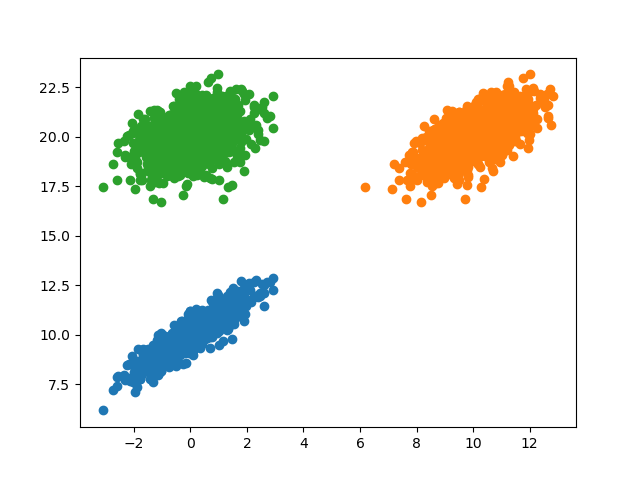

In [28]:
ab = 0.9
bc = 0.6
ac = 0.3
cov3 = np.array(
    [[1, ab, ac], 
     [ab, 1, bc],
     [ac, bc, 1]])
# mvar3 = rng.multivariate_normal(np.zeros(3), cov3, size=1000)
mvar3 = rng.multivariate_normal([0, 10, 20], cov3, size=1000)

mvar3_fig, mvar3_ax = plt.subplots(1)
mvar3_ax.scatter(mvar3[:, 0], mvar3[:, 1])
mvar3_ax.scatter(mvar3[:, 1], mvar3[:, 2])
mvar3_ax.scatter(mvar3[:, 0], mvar3[:, 2])

print("ab corr:", np.corrcoef(mvar3[:, 0], mvar3[:, 1])[0, 1])
print("bc corr:", np.corrcoef(mvar3[:, 1], mvar3[:, 2])[0, 1])
print("ac corr:", np.corrcoef(mvar3[:, 0], mvar3[:, 2])[0, 1])

Innovations or "state_shocks"
[used in this correlated AR(p) time-series example](https://stats.stackexchange.com/questions/136291/how-do-you-simulate-two-correlated-arp-time-series)
[leveraging R's arima](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/arima.sim) seem to be the 
equivalent of the distrvs param of `ArmaProcess.generate_sample`

Input variance scaling equivalent to post-process scaling: True
arma corrcoef (mvar rho 0.8): 0.785381


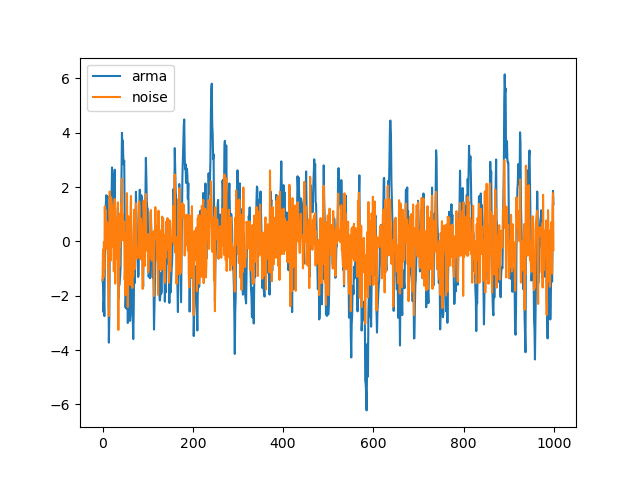

In [10]:
# arparams = np.array([.75, -.25])
# maparams = np.array([.65, .355])

# arparams = np.array([0.8])
# maparams = np.array([0])

arparams = np.array([0.9, -0.1])
maparams = np.array([0])

# arparams = np.array([0.])
# maparams = np.array([0.8])

ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag

arma_process = sm.tsa.ArmaProcess(ar, ma)
# ss = arma_process.generate_sample(1000, distrvs=mvar_fun)
ss = arma_process.generate_sample(1000, distrvs=mvar_dumb)

pre_halved = arma_process.generate_sample(10, distrvs=mvar_dumb_half)
post_halved = arma_process.generate_sample(10, distrvs=mvar_dumb) * 0.5
print("Input variance scaling equivalent to post-process scaling:", (pre_halved == post_halved).all())

arma_fig, arma_ax = plt.subplots(1)
arma_ax.plot(ss[:, 0], label="arma")
# arma_ax.plot(ss[:, 1])
arma_ax.plot(mvar[:, 0], label="noise")
arma_ax.legend()
print("arma corrcoef (mvar rho %s): %f" % (str(mvar_rho), np.corrcoef(ss[:, 0], ss[:, 1])[0, 1]))

### Rolling averages of noise innovations vs the ARMA
This demonstrates nicely that the ARMA is itself a rolling process that is incorporating the noise
into it's state at each step. The noise amplitude is reduced much more by the rolling average since neighbouring points are independent from eachother.

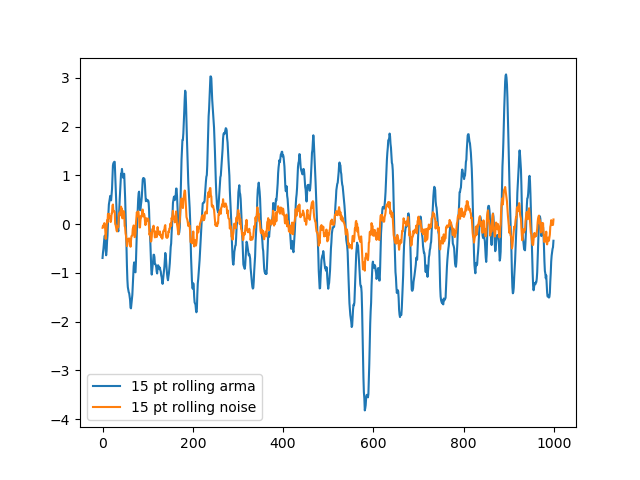

In [11]:
window = 15
roll_fig, roll_ax = plt.subplots(1)
roll_ax.plot(rolling_average(ss[:, 0], n=window), label="%i pt rolling arma" % window)
roll_ax.plot(rolling_average(mvar[:, 0], n=window), label="%i pt rolling noise" % window)
roll_ax.legend()

### Scaling ARMA innovations (distrvs) by release template to create noisey release rate transient

corrcoef: 0.7919967395077496
clipped corrcoef: 0.7919967395077496


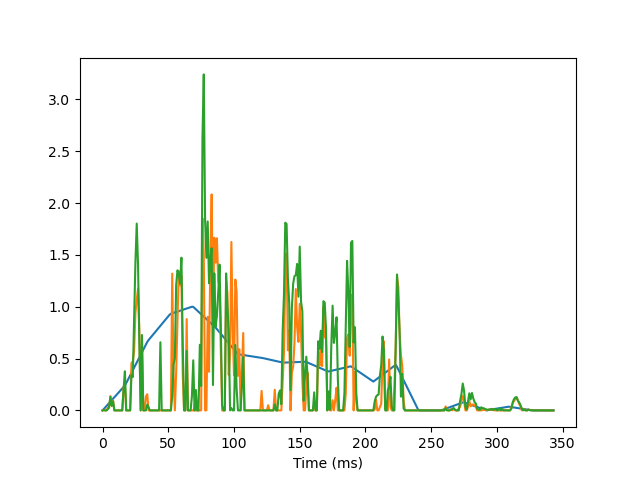

In [12]:
norm_rate = vrate / np.max(vrate)

def rate_mvar_fun(rate, factor):
    scale = rate.reshape(-1, 1) * factor
    def fun(size):
        return rng.multivariate_normal(np.zeros(2), cov, size=size) * scale
    return fun

# arparams = np.array([.75, -.25])
# maparams = np.array([.65, .355])

arparams = np.array([0.9, -0.1])
maparams = np.array([0.])

# arparams = np.array([0.])
# maparams = np.array([0.9])
# maparams = np.array([0.65, 0.355])

# arparams = np.array([.6, .3])
# maparams = np.array([0, 0])

ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag

innov_scale = 1
arma_process = sm.tsa.ArmaProcess(ar, ma)
ss = arma_process.generate_sample(len(norm_rate), distrvs=rate_mvar_fun(norm_rate, innov_scale))

arma_rate_fig, arma_rate_ax = plt.subplots(1)
arma_rate_ax.plot(norm_rate)
# arma_rate_ax.plot(norm_rate + ss[:, 0])
# arma_rate_ax.plot(norm_rate + ss[:, 1])
# arma_rate_ax.plot(np.clip(norm_rate + ss[:, 0], 0, np.inf))
# arma_rate_ax.plot(np.clip(norm_rate + ss[:, 1], 0, np.inf))
arma_rate_ax.plot(vrate_xaxis, np.clip(ss[:, 0], 0, np.inf))
arma_rate_ax.plot(vrate_xaxis, np.clip(ss[:, 1], 0, np.inf))
arma_rate_ax.set_xlabel("Time (ms)")
# arma_rate_ax.legend()
css = np.clip(ss, 0, np.inf)
print("corrcoef:", np.corrcoef(css[:, 0], css[:, 1])[0, 1])
print("clipped corrcoef:", np.corrcoef(css[:, 0], css[:, 1])[0, 1])

### Convolving release rate with biexponential quanta

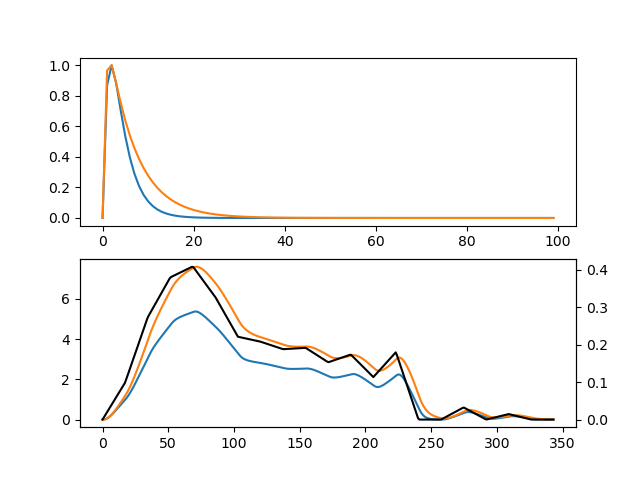

In [13]:
# quanta_xaxis = np.linspace(0, 0.50, 100)
quanta_xaxis = np.arange(100)

ach_biexp = biexp(quanta_xaxis, 1.2, 3, m=1, b=0)
ach_biexp /= np.min(ach_biexp)
gaba_biexp = biexp(quanta_xaxis, 0.6, 6, m=1, b=0)
gaba_biexp /= np.min(gaba_biexp)

ach_ex = np.convolve(norm_rate, ach_biexp, mode="full")[:len(norm_rate)]
gaba_ex = np.convolve(norm_rate, gaba_biexp, mode="full")[:len(norm_rate)]
# ach_ex = np.convolve(norm_rate, np.flip(ach_biexp), mode="same")
# gaba_ex = np.convolve(norm_rate, np.flip(gaba_biexp), mode="same")

trans_ex_fig, trans_ex_ax = plt.subplots(2)
trans_ex_ax[0].plot(quanta_xaxis, ach_biexp)
trans_ex_ax[0].plot(quanta_xaxis, gaba_biexp)
trans_ex_axr = trans_ex_ax[1].twinx()
trans_ex_axr.plot(vrate, color="black")
trans_ex_ax[1].plot(ach_ex)
# trans_ex_ax[1].plot(ach_ex / np.max(ach_ex) * np.max(gaba_ex))
trans_ex_ax[1].plot(gaba_ex)

### Release rate template with addition of release scaled correlated ARMA

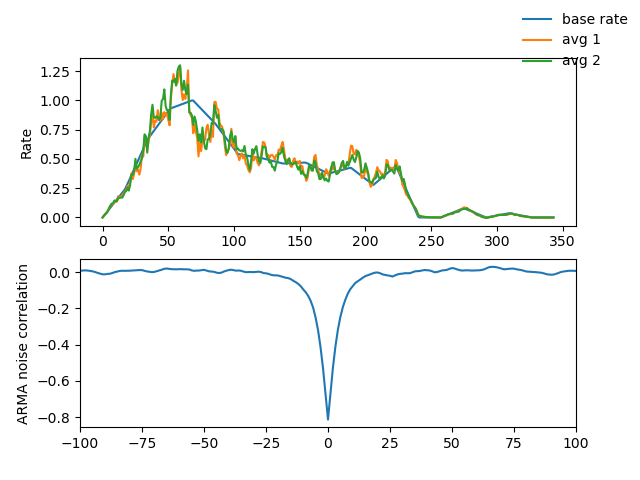

In [14]:
n_trials = 100
recs = np.zeros((n_trials, 2, len(norm_rate)))
xcorrs = np.zeros((n_trials, len(norm_rate) * 2 - 1))
for i in range(n_trials):
    noise = arma_process.generate_sample(len(norm_rate), distrvs=rate_mvar_fun(norm_rate, innov_scale))
    recs[i] = norm_rate + noise.T
    xcorrs[i] = norm_xcorr(noise[:, 0], noise[:, 1] * -1, mode="full")

avg_recs = np.mean(recs, axis=0)
full_xaxis = np.concatenate([np.flip(vrate_xaxis[1:] * -1), vrate_xaxis])

arma_avg_rate_fig, arma_avg_rate_ax = plt.subplots(2)
arma_avg_rate_ax[0].plot(norm_rate, label="base rate")
arma_avg_rate_ax[0].plot(avg_recs[0], label="avg 1")
arma_avg_rate_ax[0].plot(avg_recs[1], label="avg 2")
arma_avg_rate_ax[1].plot(full_xaxis, np.mean(xcorrs, axis=0))
arma_avg_rate_ax[0].set_ylabel("Rate")
arma_avg_rate_ax[1].set_ylabel("ARMA noise correlation")

arma_avg_rate_ax[1].set_xlim(-100, 100)
arma_avg_rate_fig.legend(frameon=False)

### Quantal sums of Poisson trains generated from ARMA generated release rates

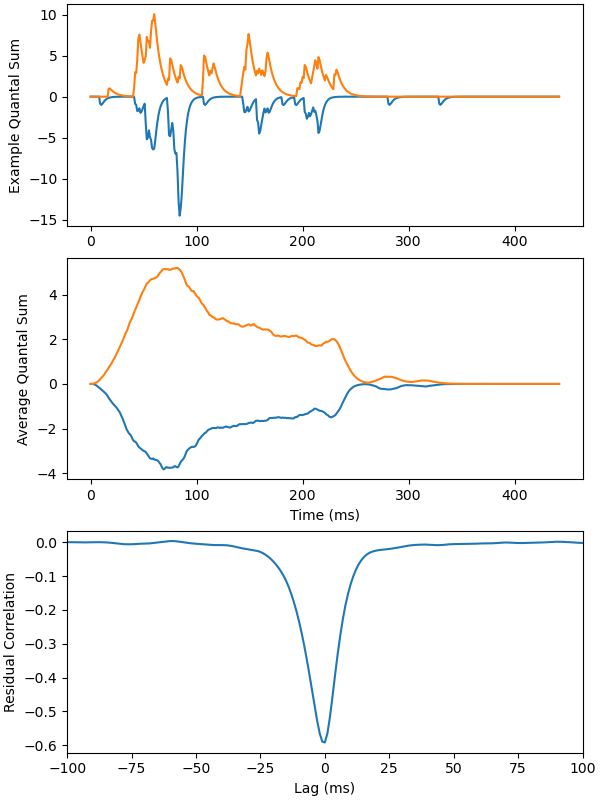

In [15]:
dt = 1
rng = np.random.default_rng()
dummy_psn = poisson_of_release(rng, vrate)
dummy_qsum = sum_quanta(dummy_psn, np.arange(len(dummy_psn)) * dt, ach_biexp, dt)

arma_mode = True
base_scale = 0
innov_scale = 1.
arparams = np.array([0.9, -0.1])
# arparams = np.array([0.95, -0.1])
maparams = np.array([0.])

# arparams = np.array([.75, -.25])
# maparams = np.array([.65, .355])
# arparams = np.array([0])
# maparams = np.array([0.9])

ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
arma_process = sm.tsa.ArmaProcess(ar, ma)

# ach_biexp = biexp(quanta_xaxis, 0.14 , 0.54, m=1, b=0)
ach_biexp = biexp(quanta_xaxis, 1.2 , 3, m=1, b=0)
# gaba_biexp = biexp(quanta_xaxis, 0.14, 2, m=1, b=0)
gaba_biexp = biexp(quanta_xaxis, 0.6, 6, m=1, b=0)
ach_biexp /= np.min(ach_biexp)
gaba_biexp /= np.min(gaba_biexp)

n_trials = 1000
qsum_recs = np.zeros((n_trials, 2, len(dummy_qsum)))
qsum_xcorrs = np.zeros((n_trials, len(dummy_qsum) * 2 - 1))
qsum_xaxis = np.arange(len(dummy_qsum)) * dt
for i in range(n_trials):
    if arma_mode:
        noise = arma_process.generate_sample(len(norm_rate), distrvs=rate_mvar_fun(norm_rate, innov_scale))
        ach_rate = base_scale * norm_rate + noise[:, 0] 
        gaba_rate = base_scale * norm_rate + noise[:, 1]
        ach_psn = poisson_of_release(rng, ach_rate)
        gaba_psn = poisson_of_release(rng, gaba_rate)
    else:
        _, ach_psn, gaba_psn = poisson_shared_base(rng, vrate, rho=0.9, i_scale=1, e_scale=1)
    qsum_recs[i, 0] = sum_quanta(ach_psn, np.arange(len(ach_psn)) * dt, ach_biexp, dt) * -1
    qsum_recs[i, 1] = sum_quanta(gaba_psn, np.arange(len(gaba_psn)) * dt, gaba_biexp, dt)

avg_qsum_recs = np.mean(qsum_recs, axis=0)
qsum_rec_resid = qsum_recs - np.expand_dims(avg_qsum_recs, 0)
for i in range(n_trials):
     qsum_xcorrs[i] = norm_xcorr(qsum_rec_resid[i, 0], qsum_rec_resid[i, 1], mode="full")
        
avg_qsum_xcorr = np.mean(qsum_xcorrs, axis=0)

full_qsum_xaxis = np.concatenate([np.flip(qsum_xaxis[1:] * -1), qsum_xaxis])
poisson_qsum_fig, poisson_qsum_ax = plt.subplots(3, figsize=(6, 8))
poisson_qsum_ax[0].plot(qsum_xaxis, qsum_recs[0, 0])
poisson_qsum_ax[0].plot(qsum_xaxis, qsum_recs[0, 1])
poisson_qsum_ax[1].plot(qsum_xaxis, avg_qsum_recs[0])
poisson_qsum_ax[1].plot(qsum_xaxis, avg_qsum_recs[1])
poisson_qsum_ax[2].plot(full_qsum_xaxis, avg_qsum_xcorr)
poisson_qsum_ax[2].set_xlim(-100, 100)
poisson_qsum_ax[0].set_ylabel("Example Quantal Sum")
poisson_qsum_ax[1].set_ylabel("Average Quantal Sum")
poisson_qsum_ax[2].set_ylabel("Residual Correlation")
poisson_qsum_ax[1].set_xlabel("Time (ms)")
poisson_qsum_ax[2].set_xlabel("Lag (ms)")
poisson_qsum_fig.set_layout_engine("compressed")